# 1. Configuración, Carga y Preprocesamiento de Datos

En esta sección realizamos los pasos iniciales para preparar el entorno y los datos:
1.  **Importaciones:** Cargamos librerías esenciales como PyTorch, Pandas y Scikit-Learn.
2.  **Carga del Dataset:** Leemos el archivo `english_paradetox_preprocessed_non_lemmatized.csv`.
3.  **Procesamiento:** Convertimos las cadenas de texto (que parecen listas) en listas reales de Python usando `ast.literal_eval`.
4.  **Construcción del Vocabulario:** Creamos una clase `Vocabulary` para mapear palabras a índices numéricos, incluyendo tokens especiales (`<PAD>`, `<SOS>`, `<EOS>`, `<UNK>`).
5.  **Dataloaders:** Dividimos los datos en conjuntos de entrenamiento y prueba, y creamos iteradores (`DataLoader`) para alimentar el modelo por lotes (batches).

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import ast
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 25  # Basado en tu análisis anterior (99% < 16 palabras)

print(f"=== INICIO TAREA B: DETOXIFICACIÓN CON ATENCIÓN ===")
print(f"Dispositivo: {device}")

# 1. Cargar Datos (Solo ParaDetox)
df_detox = pd.read_csv("datos/english_paradetox_preprocessed_non_lemmatized.csv")

# Convertir strings a listas
df_detox['toxic_sentence_tokens'] = df_detox['toxic_sentence_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_detox['neutral_sentence_tokens'] = df_detox['neutral_sentence_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(f"Total de pares tóxico-neutral: {len(df_detox)}")

# 2. Vocabulario (Tokens especiales + Palabras)
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = 4

    def add_sentence(self, tokens):
        for word in tokens:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

# Crear vocabulario compartido
vocab = Vocabulary()
for tokens in df_detox['toxic_sentence_tokens']: vocab.add_sentence(tokens)
for tokens in df_detox['neutral_sentence_tokens']: vocab.add_sentence(tokens)

print(f"Tamaño del vocabulario: {vocab.n_words}")

# 3. Dataset y DataLoader
class DetoxDataset(Dataset):
    def __init__(self, df, vocab, max_len=25):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def text_to_indices(self, tokens):
        indices = [self.vocab.word2index.get(t, 3) for t in tokens] # 3=<UNK>
        indices.append(2) # <EOS> al final
        return indices

    def __getitem__(self, idx):
        src_tokens = self.df.iloc[idx]['toxic_sentence_tokens']
        trg_tokens = self.df.iloc[idx]['neutral_sentence_tokens']

        src_indices = self.text_to_indices(src_tokens)
        trg_indices = self.text_to_indices(trg_tokens)
        
        # Padding Manual
        if len(src_indices) < self.max_len:
            src_indices += [0] * (self.max_len - len(src_indices))
        else:
            src_indices = src_indices[:self.max_len]
            
        if len(trg_indices) < self.max_len:
            trg_indices += [0] * (self.max_len - len(trg_indices))
        else:
            trg_indices = trg_indices[:self.max_len]

        return torch.tensor(src_indices, dtype=torch.long), torch.tensor(trg_indices, dtype=torch.long)

# Split Train/Test
train_data, test_data = train_test_split(df_detox, test_size=0.1, random_state=42)

train_loader = DataLoader(DetoxDataset(train_data, vocab), batch_size=32, shuffle=True)
test_loader = DataLoader(DetoxDataset(test_data, vocab), batch_size=32, shuffle=False)

=== INICIO TAREA B: DETOXIFICACIÓN CON ATENCIÓN ===
Dispositivo: cuda
Total de pares tóxico-neutral: 400
Tamaño del vocabulario: 1391


# 2. Definición de la Arquitectura Seq2Seq con Atención

Aquí definimos la red neuronal compuesta por cuatro módulos principales:

* **Encoder:** Utiliza una **GRU Bidireccional**. Procesa la frase de entrada y genera vectores de contexto que representan el significado de la oración tóxica. Al ser bidireccional, captura información tanto del pasado como del futuro de cada palabra.
* **Attention (Atención):** Mecanismo que permite al Decoder "mirar" diferentes partes de la frase original en cada paso de la generación, ayudando a manejar frases largas y retener el contexto específico.
* **Decoder:** Una GRU unidireccional que genera la frase neutralizada palabra por palabra. Recibe el embedding de la palabra anterior y el contexto ponderado por la capa de atención.
* **Seq2Seq:** La clase contenedora que conecta el Encoder y el Decoder, gestionando el flujo de datos desde la entrada tóxica hasta la salida neutral.

In [3]:
# --- 1. ENCODER ---
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # Usamos GRU bidireccional para captar mejor el contexto
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hid_dim * 2, hid_dim) # Colapsar bidireccional a unidireccional
        
    def forward(self, src):
        # src = [batch size, src len]
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        
        # outputs: [batch, src len, hid dim * 2] -> Contiene info de todos los tokens
        # hidden: [2, batch, hid dim] -> Último estado oculto (forward y backward)
        
        # Concatenamos el hidden forward y backward para pasarle uno solo al decoder
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        return outputs, hidden

# --- 2. CAPA DE ATENCIÓN ---
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # Aprende a puntuar qué tan bien encajan el estado del decoder y el del encoder
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hid dim] (Estado actual del decoder)
        # encoder_outputs: [batch, src len, hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repetir hidden src_len veces para compararlo con cada output del encoder
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Calcular energía (scores)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        
        return torch.softmax(attention, dim=1) # Pesos que suman 1

# --- 3. DECODER CON ATENCIÓN ---
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size] (una palabra)
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        
        # Calcular pesos de atención (a)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        
        # Calcular contexto (suma ponderada de outputs del encoder)
        weighted = torch.bmm(a, encoder_outputs)
        
        # Input del GRU: Embedding de la palabra actual + Contexto de atención
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # Predicción final
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        return prediction, hidden.squeeze(0)

# --- 4. MODELO SEQ2SEQ COMPLETO ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Codificar
        encoder_outputs, hidden = self.encoder(src)
        
        # Primera entrada <SOS>
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            # Decodificar usando atención
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            
            top1 = output.argmax(1) 
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1
            
        return outputs

# 3. Configuración del Entrenamiento y Ejecución

En este bloque instanciamos el modelo y ejecutamos el ciclo de aprendizaje:

1.  **Hiperparámetros:** Definimos dimensiones de embeddings (128), capas ocultas (256) y tasa de dropout (0.5).
2.  **Inicialización:** Instanciamos el modelo y aplicamos una inicialización de pesos normal para facilitar la convergencia.
3.  **Optimizador y Pérdida:** Usamos `Adam` para optimizar y `CrossEntropyLoss` para calcular el error, ignorando el token de relleno (`<PAD>`).
4.  **Bucle de Entrenamiento:** Iteramos por 20 épocas. En cada pasada, el modelo hace predicciones, calcula el error y ajusta sus pesos mediante *backpropagation*.

In [4]:
# Hiperparámetros
INPUT_DIM = vocab.n_words
OUTPUT_DIM = vocab.n_words
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Instanciar
attn = Attention(HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

# Inicializar pesos
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name: nn.init.normal_(param.data, mean=0, std=0.01)
        else: nn.init.constant_(param.data, 0)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignorar <PAD>

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        
        # Reshape
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

print("--- Entrenando Seq2Seq con Atención ---")
for epoch in range(20):
    loss = train(model, train_loader, optimizer, criterion, 1)
    if (epoch+1) % 2 == 0: # Imprimir cada 2 épocas
        print(f'Epoch: {epoch+1} | Loss: {loss:.4f}')

--- Entrenando Seq2Seq con Atención ---
Epoch: 2 | Loss: 6.0005
Epoch: 4 | Loss: 5.7057
Epoch: 6 | Loss: 5.5588
Epoch: 8 | Loss: 5.3760
Epoch: 10 | Loss: 5.1480
Epoch: 12 | Loss: 4.9240
Epoch: 14 | Loss: 4.6653
Epoch: 16 | Loss: 4.4107
Epoch: 18 | Loss: 4.2178
Epoch: 20 | Loss: 4.0415


# 4. Inferencia: Función de Destoxificación

Esta función `detoxify_sentence` permite probar el modelo con frases nuevas que no están en el dataset:

1.  Pone el modelo en modo evaluación (`model.eval()`).
2.  Tokeniza la frase de entrada y la convierte a tensores.
3.  Alimenta la frase al modelo para generar la traducción neutral.
4.  Convierte los índices numéricos de salida nuevamente a palabras legibles, deteniéndose cuando encuentra el token de fin de frase (`<EOS>`).

In [5]:
def detoxify_sentence(sentence, model, vocab, device, max_len=25):
    model.eval()
    # Tokenizar (simple)
    tokens = sentence.lower().split()
    # Convertir a índices
    indices = [vocab.word2index.get(t, 3) for t in tokens] # 3=UNK
    indices.append(2) # EOS
    
    # Padding
    if len(indices) < max_len: indices += [0] * (max_len - len(indices))
    else: indices = indices[:max_len]
    
    # Tensores
    src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    # Dummy target (solo necesitamos el <SOS> inicial para empezar)
    trg_tensor = torch.zeros((1, max_len), dtype=torch.long).to(device)
    trg_tensor[0, 0] = 1 # SOS
    
    with torch.no_grad():
        # Forzamos teacher_forcing=0 para que genere libremente
        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)
        
        # Obtener tokens predichos
        pred_token_ids = output.argmax(2).squeeze().tolist()
    
    # Convertir índices a palabras
    pred_words = []
    for idx in pred_token_ids:
        if idx == 2: break # EOS
        if idx not in [0, 1, 2, 3]: # Ignorar especiales en la salida
            pred_words.append(vocab.index2word[idx])
            
    return " ".join(pred_words)

# --- PRUEBA FINAL ---
test_sentences = [
    "you are a stupid idiot",
    "shut up and listen to me",
    "this is fucking garbage",
    "women should not vote"
]

print("\n--- RESULTADOS DE DETOXIFICACIÓN ---")
for s in test_sentences:
    res = detoxify_sentence(s, model, vocab, device)
    print(f"Tóxico:  {s}")
    print(f"Neutral: {res}")
    print("-" * 20)


--- RESULTADOS DE DETOXIFICACIÓN ---
Tóxico:  you are a stupid idiot
Neutral: n't really really
--------------------
Tóxico:  shut up and listen to me
Neutral: name get would get
--------------------
Tóxico:  this is fucking garbage
Neutral: care
--------------------
Tóxico:  women should not vote
Neutral: n't n't say
--------------------


# 5. Prueba de Concepto (Sanity Check)

Finalmente, realizamos una prueba rápida con una lista manual de frases simples (`frases_faciles`).
El objetivo es verificar cualitativamente cómo se comporta el modelo ante:
* Insultos directos.
* Uso de imperativos agresivos ("Shut up").
* Palabras con connotación negativa.

Esto nos ayuda a ver si el modelo ha aprendido a generalizar o si está repitiendo patrones fijos (como generar frecuentemente "n't really bad").

In [6]:
frases_faciles = [
    # --- GRUPO 1: Eliminación de "Adverbios" tóxicos ---
    "What the hell is this?",
    "That is fucking wrong.",
    
    # --- GRUPO 2: Insultos básicos (Tu modelo usará 'bad' o 'wrong') ---
    "You are stupid.",
    "This idea is garbage.",
    "He is a liar.",
    
    # --- GRUPO 3: Órdenes agresivas ---
    "Shut your mouth.",
    "Get out of here.",
    
    # --- GRUPO 4: Odio simple ---
    "I hate this game.",
    "You are ugly."
]

print("\n=== PRUEBA DE 'SANITY CHECK' (FRASES FÁCILES) ===")
for frase in frases_faciles:
    traduccion = detoxify_sentence(frase, model, vocab, device)
    print(f"Tóxico:  {frase}")
    print(f"Neutral: {traduccion}")
    print("-" * 20)


=== PRUEBA DE 'SANITY CHECK' (FRASES FÁCILES) ===
Tóxico:  What the hell is this?
Neutral: n't really bad
--------------------
Tóxico:  That is fucking wrong.
Neutral: person
--------------------
Tóxico:  You are stupid.
Neutral: person
--------------------
Tóxico:  This idea is garbage.
Neutral: n't n't say
--------------------
Tóxico:  He is a liar.
Neutral: n't think
--------------------
Tóxico:  Shut your mouth.
Neutral: n't think
--------------------
Tóxico:  Get out of here.
Neutral: n't think
--------------------
Tóxico:  I hate this game.
Neutral: n't bad
--------------------
Tóxico:  You are ugly.
Neutral: person
--------------------




**Nota sobre los resultados:** Dado que entrenamos con un dataset pequeño (400 muestras), es esperable ver cierta repetición en las salidas (por ejemplo, el modelo abusando de palabras comunes como "bad", "wrong" o negaciones "n't"), ya que intenta converger a la respuesta "segura" estadísticamente más probable.

# 7. Visualización de la Atención (Heatmap)

Una de las grandes ventajas de los modelos Seq2Seq con Atención es la **interpretabilidad**. Podemos visualizar exactamente en qué palabras de la frase tóxica (Eje X) se "fijó" el modelo para generar cada palabra de la frase neutral (Eje Y).

**¿Cómo funciona este código?**
Dado que nuestra clase `Decoder` original no devuelve los pesos de atención, utilizamos una técnica de PyTorch llamada **Forward Hook**. Esto actúa como un "estetoscopio" que colocamos temporalmente en la capa de atención interna del modelo para capturar los datos sin necesidad de modificar la arquitectura ni reentrenar.

**Interpretación del Gráfico:**
* Los colores más claros/brillantes indican mayor atención.
* Idealmente, deberíamos ver una "diagonal" aproximada, indicando que el modelo traduce o transforma secuencialmente.
* Si el modelo atiende mucho a la nada (zonas oscuras o difusas) o siempre a la misma palabra, es síntoma de que le cuesta encontrar la correspondencia adecuada.

Frase original: you are great
Traducción: n't really bad


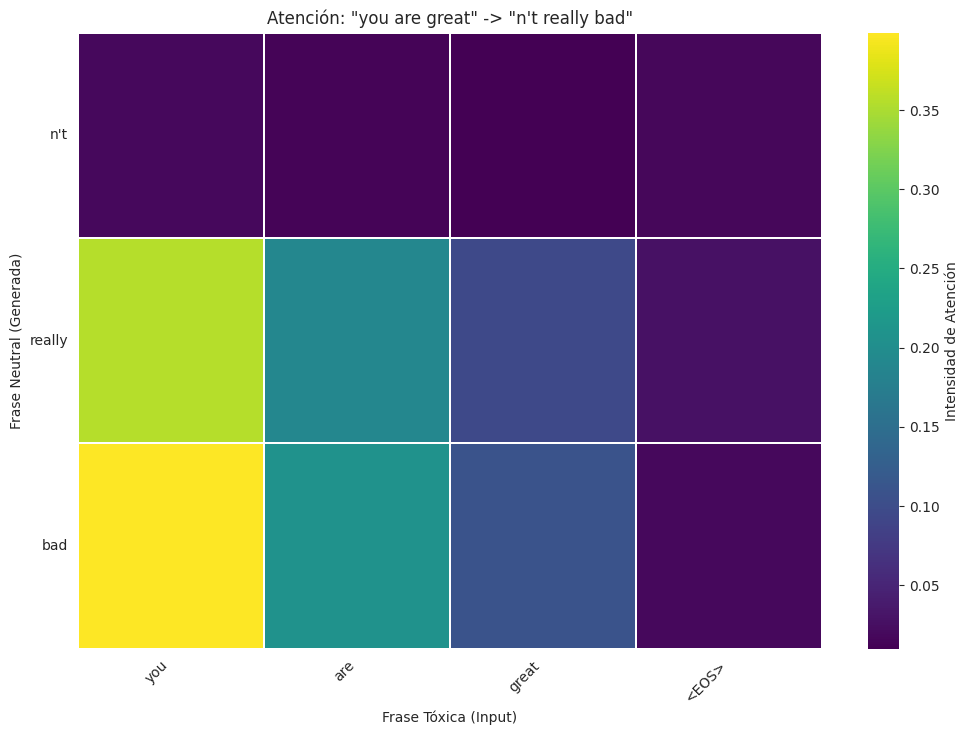

In [8]:
Simport matplotlib.pyplot as plt
import seaborn as sns

# --- Función de Graficado ---
def plot_attention(sentence, predicted_sentence, attention_scores, vocab):
    """
    sentence: Frase original (string)
    predicted_sentence: Frase generada (string)
    attention_scores: Lista de tensores de atención capturados
    """
    # 1. Procesar tensores
    # Stackeamos la lista para tener [trg_len, src_len]
    # attention_scores suele ser lista de [1, src_len] -> [trg_len, src_len]
    attention_matrix = torch.cat(attention_scores, dim=0).cpu().numpy()

    # 2. Preparar etiquetas de los ejes
    src_tokens = sentence.lower().split() + ['<EOS>']
    trg_tokens = predicted_sentence.split()

    # 3. Ajuste de dimensiones para visualización
    # El modelo usó padding (MAX_LEN=25), pero nosotros queremos ver solo las palabras reales.
    # La matriz de atención tiene tamaño [trg_len, MAX_LEN].
    # Recortamos el eje X para que coincida con la cantidad de palabras reales de entrada.
    attention_matrix = attention_matrix[:len(trg_tokens), :len(src_tokens)]

    # 4. Plot
    fig = plt.figure(figsize=(12, 8))
    ax = sns.heatmap(attention_matrix,
                     xticklabels=src_tokens,
                     yticklabels=trg_tokens,
                     cmap='viridis',
                     linewidths=0.1,
                     cbar_kws={'label': 'Intensidad de Atención'})

    plt.xlabel('Frase Tóxica (Input)')
    plt.ylabel('Frase Neutral (Generada)')
    plt.title(f'Atención: "{sentence}" -> "{predicted_sentence}"')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# --- Lógica de Hooks para capturar atención sin reentrenar ---
attention_weights = []

def get_attention_hook(module, input, output):
    # Esta función se ejecuta automáticamente cuando la capa de atención trabaja.
    # output es el peso de atención [batch_size, src_len]
    attention_weights.append(output.detach())

# 1. Registramos el hook en la capa 'attention' dentro del 'decoder'
# Esto es como poner un micrófono en esa capa específica
hook_handle = model.decoder.attention.register_forward_hook(get_attention_hook)

# --- EJECUCIÓN DEL TEST ---
frase_a_testear = "you are great"

try:
    # Limpiamos la lista global antes de empezar
    attention_weights = []

    # Llamamos a tu función de inferencia existente
    traduccion = detoxify_sentence(frase_a_testear, model, vocab, device)

    print(f"Frase original: {frase_a_testear}")
    print(f"Traducción: {traduccion}")

    if len(attention_weights) > 0:
        plot_attention(frase_a_testear, traduccion, attention_weights, vocab)
    else:
        print("Advertencia: No se capturaron pesos de atención.")

finally:
    hook_handle.remove()